In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# import random

from scipy.integrate import solve_ivp
import torch 

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

import pysindy as ps

In [3]:
# Чтобы при вызове print или display после точки выводилось фиксированное число знаков

# np.set_printoptions(precision=5, suppress=True)

# Генерация наших данных

Начальные концентрации:        [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
Сумма концентрций веществ:  0.9999999999999999
[5.19498155e-06 1.54594957e-03 1.80646380e-03 6.22171901e-07
 3.98887190e-06]


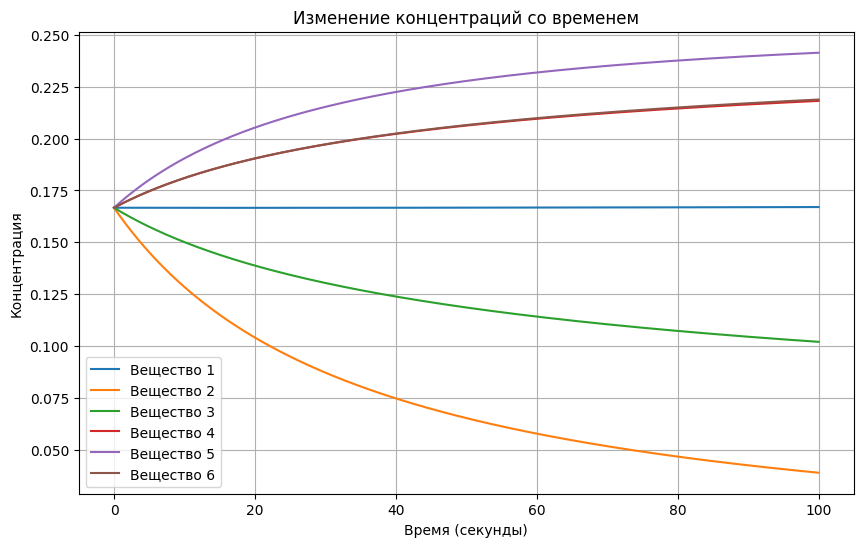

Концентрации после 100 секунд: [0.16699309 0.03907172 0.1021     0.21811198 0.24130944 0.21876702]
Сумма концентрций веществ:  0.9863532425341756


In [2]:
# random.seed(1)

# Константы
N_REACTION = 5                                                                # реакций
N_SUBSTANCE = 6                                                               # веществ
A = np.array([100000000, 90000000, 85000000, 110000000, 95000000])
Ea= np.array([70000, 60000, 55000, 80000, 75000])
R = 8.314
temp = 300
vr_time = 100
H = 0.01
MATR = np.array([
    [-2, -1, 1, 1, 0, 0],
    [0, -2, 1, 0, 2, 0],
    [0, -1, -2, 1, 0, 1],
    [1, 0, 0, -2, 1, 0],
    [1, 0, 0, 0, -2, 1]
])

# Матрица порядков реакций
MATR_PLUS = np.where(MATR < 0, -MATR, 0)
k = A * np.exp(-Ea / (R * temp)) * (temp**0.5)

# Переменные, будут заводиться отдельно
C = np.full(N_SUBSTANCE, 1 / N_SUBSTANCE)
print("Начальные концентрации:       ", C)
print("Сумма концентрций веществ: ", sum(C))

# Список для хранения концентраций на каждом шаге времени
concentration_history = [C.copy()]

print(np.array([k[j] * np.prod(C**MATR_PLUS.T[:, j]) for j in range(N_REACTION)]))

def dC_dt(C):
    W = np.array([k[j] * np.prod(C**MATR_PLUS.T[:, j]) for j in range(N_REACTION)])  # Скорость для каждой реакции
    dC = MATR.T @ W  # Изменение концентраций
    return dC

time_steps = int(vr_time / H)
for _ in range(time_steps):
    dC = dC_dt(C)
    C += dC * H
    concentration_history.append(C.copy())

concentration_history = np.array(concentration_history)

# Построение графика
time = np.linspace(0, vr_time, time_steps + 1)
plt.figure(figsize=(10, 6))
for i in range(N_SUBSTANCE):
    plt.plot(time, concentration_history[:, i], label=f"Вещество {i+1}")

plt.title("Изменение концентраций со временем")
plt.xlabel("Время (секунды)")
plt.ylabel("Концентрация")
plt.legend()
plt.grid()
plt.show()

print(f"Концентрации после {vr_time} секунд: {C}")
print("Сумма концентрций веществ: ", sum(C))


# Генерация данных нашим подходом, но для CRNN-модели

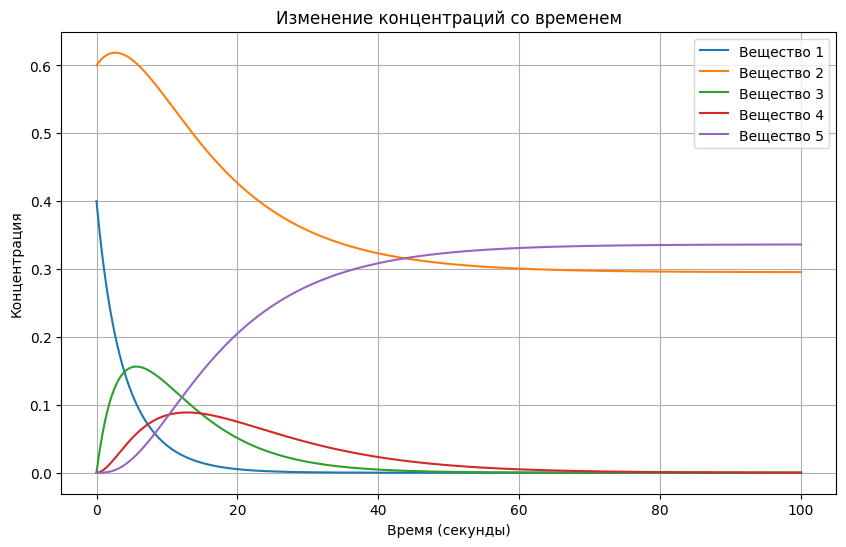

Начальные концентрации:        [0.4 0.6 0.  0.  0. ]
Сумма концентрций веществ:  1.0
Концентрации после 100 секунд: [5.76835235e-10 2.95556209e-01 1.99073588e-06 1.67152430e-04
 3.36239480e-01]
Сумма концентрций веществ:  0.6319648320602071


In [3]:
# random.seed(1)

# Константы
N_REACTION = 4                                                               # реакций
N_SUBSTANCE = 5                                                              # веществ
vr_time = 100
H = 0.01
MATR = np.array([
    [-2, 1, 0, 0, 0],
    [-1, 0, 1, 0, 0],
    [0, 0, -1, 1, 0],
    [0, -1, 0, -1, 1]
])

# Матрица порядков реакций
MATR_PLUS = np.where(MATR < 0, -MATR, 0)
k = torch.tensor([0.1, 0.2, 0.13, 0.3], dtype=torch.float32)

# Переменные, будут заводиться отдельно
C0 = np.array([0.4, 0.6, 0, 0, 0])
C = np.array([0.4, 0.6, 0, 0, 0])

# Список для хранения концентраций на каждом шаге времени
concentration_history = [C.copy()]

def dC_dt(C):
    W = np.array([k[j] * np.prod(C**MATR_PLUS.T[:, j]) for j in range(N_REACTION)])  # Скорость для каждой реакции
    dC = MATR.T @ W  # Изменение концентраций
    return dC

time_steps = int(vr_time / H)
for _ in range(time_steps):
    dC = dC_dt(C)
    C += dC * H
    concentration_history.append(C.copy())

concentration_history = np.array(concentration_history)

# Построение графика
time = np.linspace(0, vr_time, time_steps + 1)
plt.figure(figsize=(10, 6))
for i in range(N_SUBSTANCE):
    plt.plot(time, concentration_history[:, i], label=f"Вещество {i+1}")

plt.title("Изменение концентраций со временем")
plt.xlabel("Время (секунды)")
plt.ylabel("Концентрация")
plt.legend()
plt.grid()
plt.show()

print("Начальные концентрации:       ", C0)
print("Сумма концентрций веществ: ", sum(C0))

print(f"Концентрации после {vr_time} секунд: {C}")
print("Сумма концентрций веществ: ", sum(C))


# Вариант генерации в CRNN-модели

## Test 1

In [4]:
def true_ode_func(t, y, k):
    """
    Вычисляет производные системы дифференциальных уравнений.
    
    Параметры:
    t : float
        Время (не используется в данном уравнении, но необходим для совместимости с solve_ivp).
    y : array-like
        Вектор переменных (y[0], y[1], ..., y[4]).
    k : array-like
        Коэффициенты (k[0], k[1], ..., k[4]).

    Возвращает:
    dydt : numpy.ndarray
        Вектор производных.
    """
    dydt = np.zeros_like(y)
    dydt[0] = -2 * k[0] * y[0]**2 - k[1] * y[0]
    dydt[1] = k[0] * y[0]**2 - k[3] * y[1] * y[3]
    dydt[2] = k[1] * y[0] - k[2] * y[2]
    dydt[3] = k[2] * y[2] - k[3] * y[1] * y[3]
    dydt[4] = k[3] * y[1] * y[3]
    return dydt

In [5]:
# Константы
N_REACTION = 4                                                               # реакций
N_SUBSTANCE = 5                                                              # веществ
vr_time = 50                                                                # время прохождения реакций

k = torch.tensor([0.1, 0.2, 0.13, 0.3], dtype=torch.float32)
C0 = np.array([0.4, 0.6, 0, 0, 0])                                           # начальные концентрации
C = np.array([0.4, 0.6, 0, 0, 0])

tspan = [0.0, vr_time]                                                       # временной промежуток
tsteps = np.linspace(tspan[0], tspan[1], vr_time * 4)                                 # шаги по временному промежутку

sol = solve_ivp(
        true_ode_func,              # Функция ОДУ
        tspan,                      # Интервал времени
        C,                         # Начальные условия
        args=(k,),                  # Передача параметров в функцию
        method='RK45',              # Метод решения
        t_eval=tsteps               # Точки, в которых сохраняется решение (Шаг)
    )

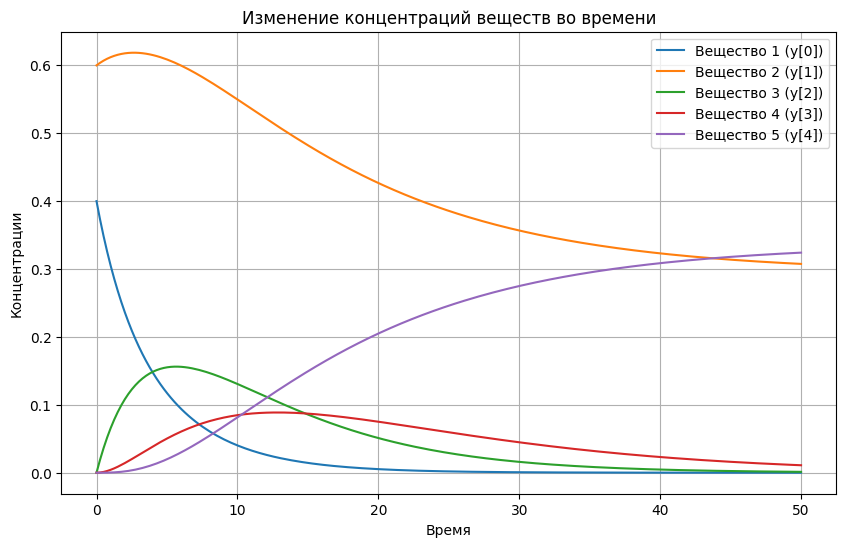

Начальные концентрации:        [0.4 0.6 0.  0.  0. ]
Сумма концентраций веществ:  1.0
Концентрации после 50 секунд: [0.02495955 0.51781497 0.10944508 0.08859621 0.11378974]
Сумма концентрций веществ:  0.8546055496714939


In [6]:
# Построение графиков
plt.figure(figsize=(10, 6))
for i in range(N_SUBSTANCE):
    plt.plot(sol.t, sol.y[i], label=f'Вещество {i+1} (y[{i}])')

plt.title('Изменение концентраций веществ во времени')
plt.xlabel('Время')
plt.ylabel('Концентрации')
plt.legend()
plt.grid(True)
plt.show()

print("Начальные концентрации:       ", C0)
print("Сумма концентраций веществ: ", sum(C0))

print(f"Концентрации после {vr_time} секунд: {sol.y[:, vr_time - 1]}")
print("Сумма концентрций веществ: ", sum(sol.y[:, vr_time - 1]))


## Test 2

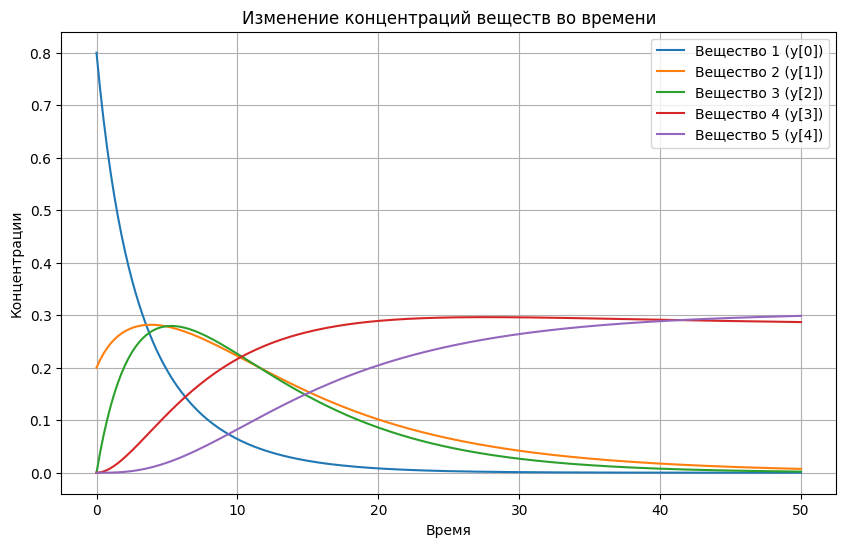

Начальные концентрации:        [0.8 0.2 0.  0.  0. ]
Сумма концентраций веществ:  1.0
Концентрации после 50 секунд: [0.03940547 0.18984074 0.18765572 0.24573059 0.11584225]
Сумма концентрций веществ:  0.7784747623437238


In [7]:
start_conc_1 = np.array([0.8, 0.2, 0, 0, 0])
sol = solve_ivp(
        true_ode_func,              # Функция ОДУ
        tspan,                      # Интервал времени
        start_conc_1,                         # Начальные условия
        args=(k,),                  # Передача параметров в функцию
        method='RK45',              # Метод решения
        t_eval=tsteps               # Точки, в которых сохраняется решение (Шаг)
    )

# Построение графиков
plt.figure(figsize=(10, 6))
for i in range(N_SUBSTANCE):
    plt.plot(sol.t, sol.y[i], label=f'Вещество {i+1} (y[{i}])')

plt.title('Изменение концентраций веществ во времени')
plt.xlabel('Время')
plt.ylabel('Концентрации')
plt.legend()
plt.grid(True)
plt.show()

print("Начальные концентрации:       ", start_conc_1)
print("Сумма концентраций веществ: ", sum(start_conc_1))

print(f"Концентрации после {vr_time} секунд: {sol.y[:, vr_time - 1]}")
print("Сумма концентрций веществ: ", sum(sol.y[:, vr_time - 1]))


## Test 3

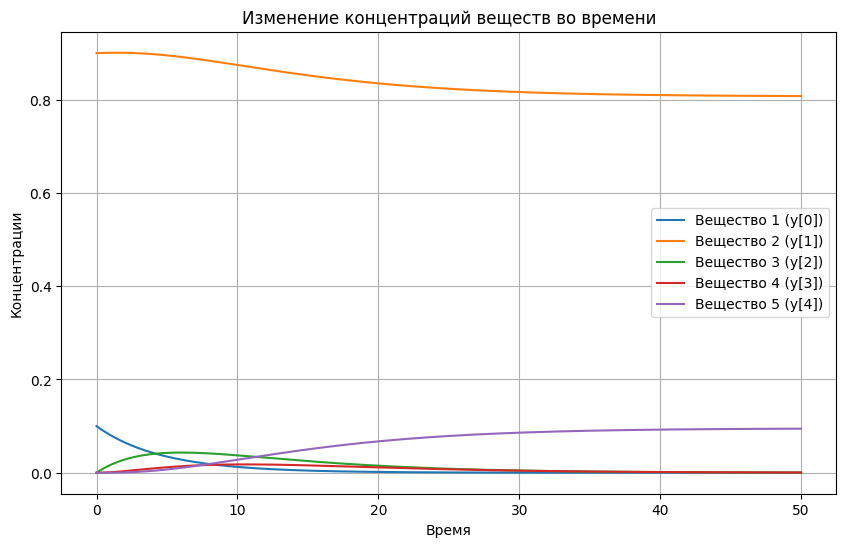

Начальные концентрации:        [0.1 0.9 0.  0.  0. ]
Сумма концентраций веществ:  1.0
Концентрации после 50 секунд: [0.00781081 0.86380216 0.03153197 0.01747113 0.03852726]
Сумма концентрций веществ:  0.959143326334844


In [8]:
start_conc_2 = np.array([0.1, 0.9, 0, 0, 0])
sol = solve_ivp(
        true_ode_func,              # Функция ОДУ
        tspan,                      # Интервал времени
        start_conc_2,                         # Начальные условия
        args=(k,),                  # Передача параметров в функцию
        method='RK45',              # Метод решения
        t_eval=tsteps               # Точки, в которых сохраняется решение (Шаг)
    )

# Построение графиков
plt.figure(figsize=(10, 6))
for i in range(N_SUBSTANCE):
    plt.plot(sol.t, sol.y[i], label=f'Вещество {i+1} (y[{i}])')

plt.title('Изменение концентраций веществ во времени')
plt.xlabel('Время')
plt.ylabel('Концентрации')
plt.legend()
plt.grid(True)
plt.show()

print("Начальные концентрации:       ", start_conc_2)
print("Сумма концентраций веществ: ", sum(start_conc_2))

print(f"Концентрации после {vr_time} секунд: {sol.y[:, vr_time - 1]}")
print("Сумма концентрций веществ: ", sum(sol.y[:, vr_time - 1]))


## Test 4

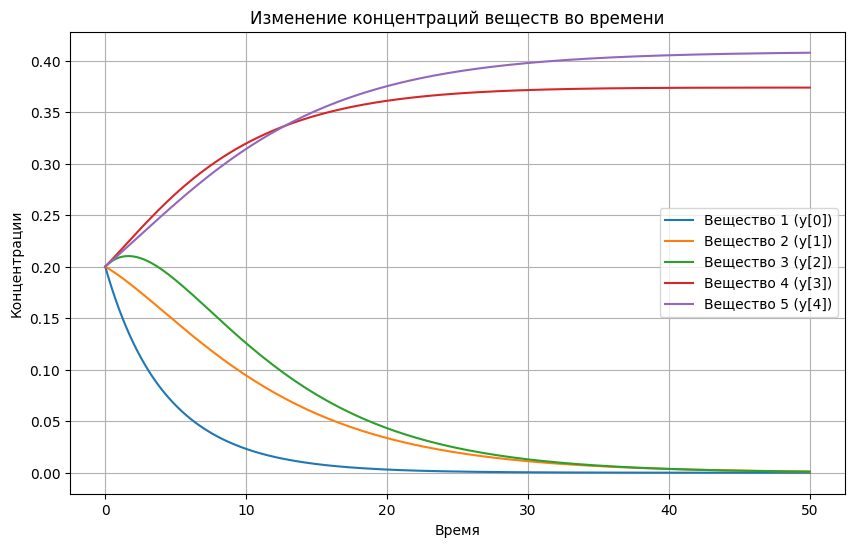

Начальные концентрации:        [0.2 0.2 0.2 0.2 0.2]
Сумма концентраций веществ:  1.0
Концентрации после 50 секунд: [0.01443435 0.07528875 0.1003474  0.33426767 0.33345769]
Сумма концентрций веществ:  0.8577958640349355


In [9]:
start_conc_3 = np.array([0.2, 0.2, 0.2, 0.2, 0.2])
sol = solve_ivp(
        true_ode_func,              # Функция ОДУ
        tspan,                      # Интервал времени
        start_conc_3,                         # Начальные условия
        args=(k,),                  # Передача параметров в функцию
        method='RK45',              # Метод решения
        t_eval=tsteps               # Точки, в которых сохраняется решение (Шаг)
    )

# Построение графиков
plt.figure(figsize=(10, 6))
for i in range(N_SUBSTANCE):
    plt.plot(sol.t, sol.y[i], label=f'Вещество {i+1} (y[{i}])')

plt.title('Изменение концентраций веществ во времени')
plt.xlabel('Время')
plt.ylabel('Концентрации')
plt.legend()
plt.grid(True)
plt.show()

print("Начальные концентрации:       ", start_conc_3)
print("Сумма концентраций веществ: ", sum(start_conc_3))

print(f"Концентрации после {vr_time} секунд: {sol.y[:, vr_time - 1]}")
print("Сумма концентрций веществ: ", sum(sol.y[:, vr_time - 1]))


## Test 4 с шумом

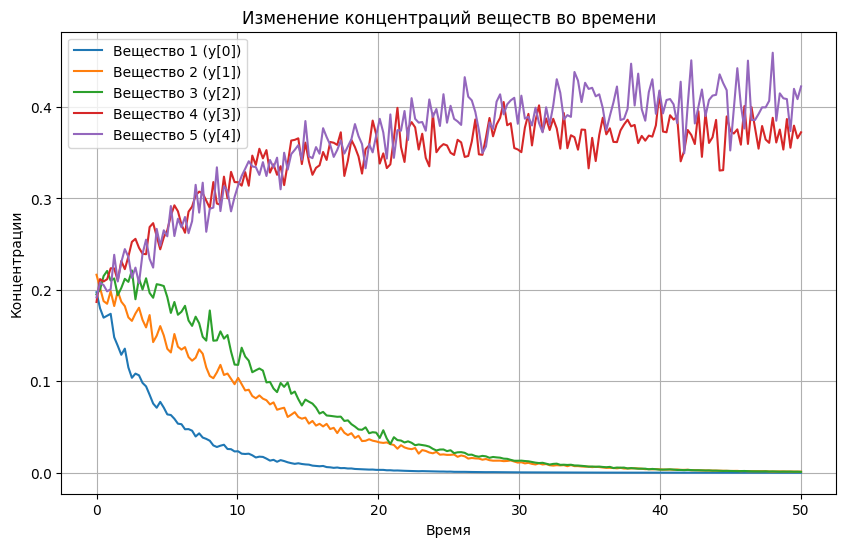

Начальные концентрации:        [0.2 0.2 0.2 0.2 0.2]
Сумма концентраций веществ:  1.0
Концентрации после 50 секунд: [0.01324734 0.07471354 0.09932131 0.32820807 0.34205041]
Сумма концентрций веществ:  0.8575406718011033


In [17]:
start_conc_3 = np.array([0.2, 0.2, 0.2, 0.2, 0.2])
sol = solve_ivp(
        true_ode_func,              # Функция ОДУ
        tspan,                      # Интервал времени
        start_conc_3,                         # Начальные условия
        args=(k,),                  # Передача параметров в функцию
        method='RK45',              # Метод решения
        t_eval=tsteps               # Точки, в которых сохраняется решение (Шаг)
    )

# Генерация шума
noise_level = 5e-2                # Уровень шума

# Построение графиков
plt.figure(figsize=(10, 6))
for i in range(N_SUBSTANCE):
    noise = np.random.randn(*sol.y[i].shape) * sol.y[i] * noise_level
    sol.y[i] = sol.y[i] + noise
    plt.plot(sol.t, sol.y[i], label=f'Вещество {i+1} (y[{i}])')

plt.title('Изменение концентраций веществ во времени')  
plt.xlabel('Время')
plt.ylabel('Концентрации')
plt.legend()
plt.grid(True)
plt.show()



print("Начальные концентрации:       ", start_conc_3)
print("Сумма концентраций веществ: ", sum(start_conc_3))
print(f"Концентрации после {vr_time} секунд: {sol.y[:, vr_time - 1]}")
print("Сумма концентрций веществ: ", sum(sol.y[:, vr_time - 1]))


In [23]:
print(len(sol.y[i]))

200


## Test 4 с шумом

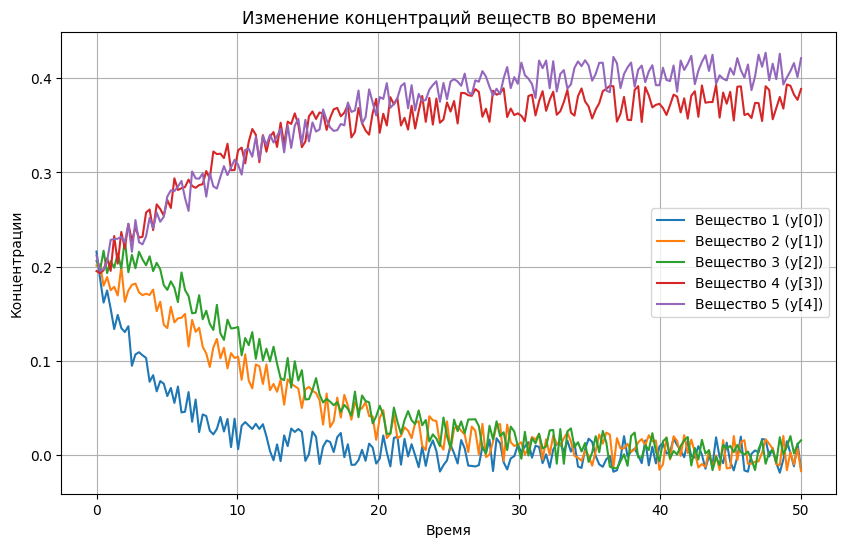

Начальные концентрации:        [0.2 0.2 0.2 0.2 0.2]
Сумма концентраций веществ:  1.0
Концентрации после 50 секунд: [0.00392428 0.068559   0.09918723 0.33812955 0.33995198]
Сумма концентрций веществ:  0.8497520354353512


In [32]:
start_conc_3 = np.array([0.2, 0.2, 0.2, 0.2, 0.2])
sol = solve_ivp(
        true_ode_func,              # Функция ОДУ
        tspan,                      # Интервал времени
        start_conc_3,                         # Начальные условия
        args=(k,),                  # Передача параметров в функцию
        method='RK45',              # Метод решения
        t_eval=tsteps               # Точки, в которых сохраняется решение (Шаг)
    )

# Генерация шума
relative_noise_scale = 0.02  # Относительная амплитуда шума (например, 20% от значения функции)

# Построение графиков
plt.figure(figsize=(10, 6))
for i in range(N_SUBSTANCE):
    noise = np.random.uniform(-relative_noise_scale, relative_noise_scale, size=sol.y[i].shape)
    sol.y[i] = sol.y[i] + noise
    plt.plot(sol.t, sol.y[i], label=f'Вещество {i+1} (y[{i}])')

plt.title('Изменение концентраций веществ во времени')  
plt.xlabel('Время')
plt.ylabel('Концентрации')
plt.legend()
plt.grid(True)
plt.show()



print("Начальные концентрации:       ", start_conc_3)
print("Сумма концентраций веществ: ", sum(start_conc_3))
print(f"Концентрации после {vr_time} секунд: {sol.y[:, vr_time - 1]}")
print("Сумма концентрций веществ: ", sum(sol.y[:, vr_time - 1]))


## Построение полиномиальных функций с помощью регрессии

[[ 1.          0.9027745   0.85144265 -0.89471799 -0.86386737]
 [ 0.9027745   1.          0.98823252 -0.91812078 -0.94897188]
 [ 0.85144265  0.98823252  1.         -0.89751085 -0.94378536]
 [-0.89471799 -0.91812078 -0.89751085  1.          0.88047701]
 [-0.86386737 -0.94897188 -0.94378536  0.88047701  1.        ]]


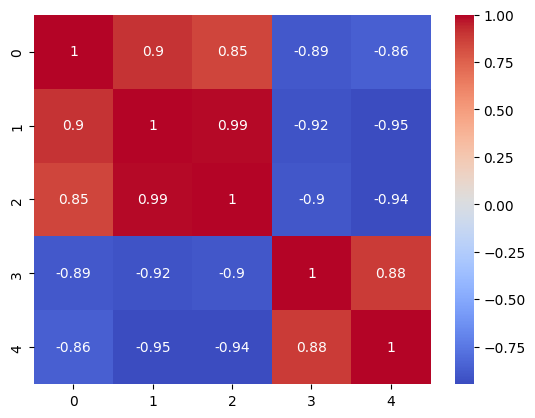

In [98]:
corr_matrix = np.corrcoef(sol.y)
print(corr_matrix)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

Для всех концентраций лучшим приближением будет полином 8 степени

Для C0 вещества:
--------------------------------------------------
Коэффициент детерминации R^2: 0.99854496
Коэффициенты полинома:
[[ 0.00000000e+00 -4.52653563e-02  5.19173914e-03 -3.73915263e-04
   1.75266863e-05 -5.27251798e-07  9.73990331e-09 -1.00103861e-10
   4.36969905e-13]]
Свободный член: 0.19935879

Для C1 вещества:
--------------------------------------------------
Коэффициент детерминации R^2: 0.99460104
Коэффициенты полинома:
[[ 0.00000000e+00 -1.37297738e-02  5.71343971e-04 -8.14632067e-05
   7.77962319e-06 -3.63781362e-07  8.93896327e-09 -1.11834699e-10
   5.63091240e-13]]
Свободный член: 0.20655768

Для C2 вещества:
--------------------------------------------------
Коэффициент детерминации R^2: 0.99418833
Коэффициенты полинома:
[[ 0.00000000e+00  1.58390400e-02 -6.10630808e-03  6.31412997e-04
  -3.56346096e-05  1.20529450e-06 -2.41899450e-08  2.64685977e-10
  -1.21376173e-12]]
Свободный член: 0.20230400

Для C3 вещества:
-----------------------------------------------

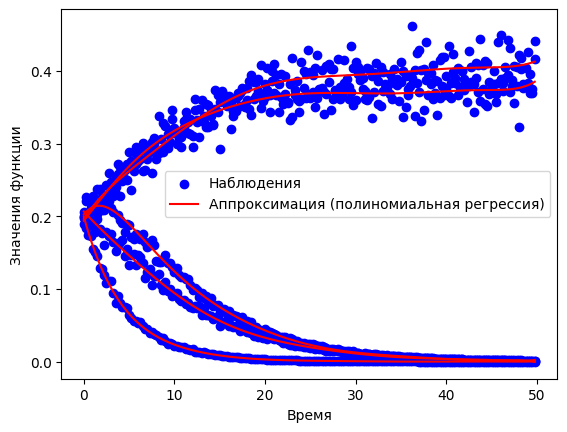

In [111]:
# Вектор значений по времмени с шагом
time_vec = np.array([i/4  for i in range(vr_time * 4)])

# Преобразование данных в нужный формат для scikit-learn
time_vec = time_vec.reshape(-1, 1)  # моменты времени как 2D массив

# Преобразование признаков в полиномиальные
poly = PolynomialFeatures(degree=8)
t_poly = poly.fit_transform(time_vec)

for i in range(N_SUBSTANCE):
    y = sol.y[i].reshape(-1, 1)  # значения функции как 2D массив

    # Создаем и обучаем модель полиномиальной регрессии
    model = LinearRegression()
    model.fit(t_poly, y)
    y_pred = model.predict(t_poly)

    # Параметры модели
    r2 = model.score(t_poly, y)
    print(f"Для C{i} вещества:")
    print("-" * 50)  # разделитель
    print(f"Коэффициент детерминации R^2: {r2:.8f}")
    print("Коэффициенты полинома:")
    print(model.coef_)
    print(f"Свободный член: {model.intercept_[0]:.8f}")
    print("=" * 50)  # разделитель
    print()

    if i == 0:
        # Визуализируем данные и аппроксимацию
        plt.scatter(time_vec, y, color='blue', label='Наблюдения')
        plt.plot(time_vec, y_pred, color='red', label='Аппроксимация (полиномиальная регрессия)')
    else:
        plt.scatter(time_vec, y, color='blue')
        plt.plot(time_vec, y_pred, color='red')

plt.xlabel('Время')
plt.ylabel('Значения функции')
plt.legend()
plt.show()




## Лог. регрессия

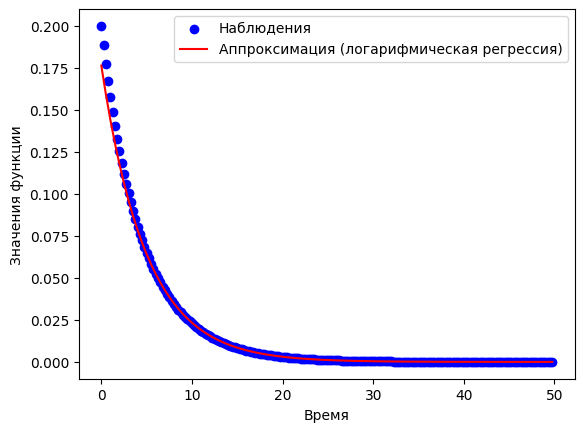

Коэффициент детерминации R^2: 0.9999023759405731

Коэффициенты логарифмической регрессии: a = [0.17636695], b = [-0.20226252]


In [121]:
time_vec = np.array([i/4 + 0.00000000001  for i in range(vr_time * 4)])
y = sol.y[0].reshape(-1, 1)  # значения функции как 2D массив

log_y = np.log(y)
time_vec = time_vec.reshape(-1, 1)

# Создаем и обучаем модель линейной регрессии
model = LinearRegression()
model.fit(time_vec, log_y)

# Получаем параметры модели
log_a = model.intercept_  # ln(a)
a = np.exp(log_a)
b = model.coef_[0]  # коэффициент b

y_pred = np.exp(model.predict(time_vec))

# Визуализируем данные и аппроксимацию
plt.scatter(time_vec, y, color='blue', label='Наблюдения')
plt.plot(time_vec, y_pred, color='red', label='Аппроксимация (логарифмическая регрессия)')
plt.xlabel('Время')
plt.ylabel('Значения функции')
plt.legend()
plt.show()

# Выводим результаты
r2 = model.score(time_vec, log_y)
print(f"Коэффициент детерминации R^2: {r2}")
print()
print(f"Коэффициенты логарифмической регрессии: a = {a}, b = {b}")

Лог. регрессия адекватно работает только для C0 вещества. Если мы априорно не знаем изменения концентрации вещества, то подогнать логарифмом анрил

## Тестирование генерации шума в данные
Генерация с добавлением шума по относительной амплитуде, используя случайные числа из диаппазона

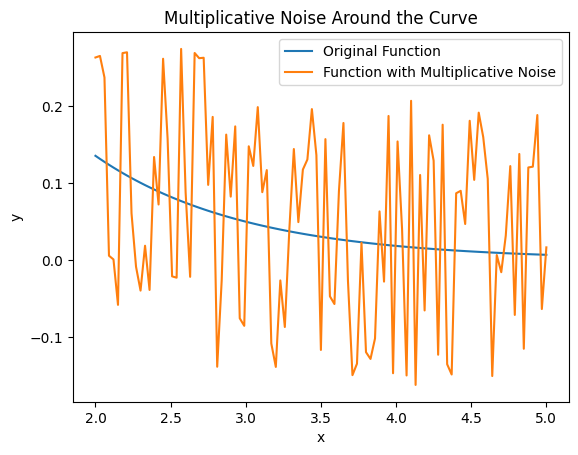

In [25]:
# Исходные данные
x = np.linspace(2, 5, 101)
y = np.exp(-x)  # Пример убывающей функции

# Генерация мультипликативного шума вокруг кривой
relative_noise_scale = 0.2  # Относительная амплитуда шума (например, 20% от значения функции)
noise = np.random.uniform(-relative_noise_scale, relative_noise_scale, size=y.shape)

# Применение шума
y_noisy = y + noise

# Визуализация
plt.plot(x, y, label='Original Function')
plt.plot(x, y_noisy, label='Function with Multiplicative Noise')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Multiplicative Noise Around the Curve')
plt.show()


In [27]:
y.shape

(101,)

Генерация с добавлением шума из стандартного нормального распределения

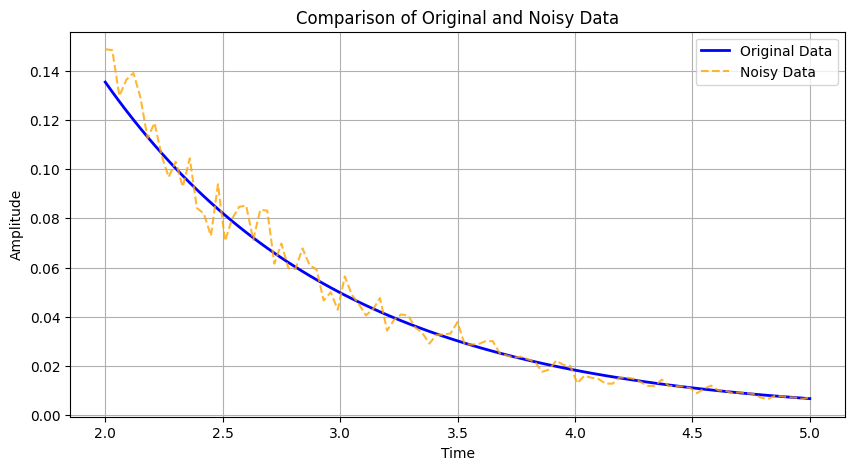

In [7]:
# Параметры
tsteps = np.linspace(2, 5, 101)  # Временные шаги
original_data = np.exp(-tsteps)        # Оригинальные данные (синусоида)
noise_level = 1e-1                # Уровень шума

# Генерация шума
noise = np.random.randn(*original_data.shape) * original_data * noise_level
noisy_data = original_data + noise

# Построение графиков
plt.figure(figsize=(10, 5))
plt.plot(tsteps, original_data, label="Original Data", linewidth=2, color='blue')
plt.plot(tsteps, noisy_data, label="Noisy Data", linestyle='--', color='orange', alpha=0.8)
plt.title("Comparison of Original and Noisy Data")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()


Второй вариант генерации шума предпочтительнее

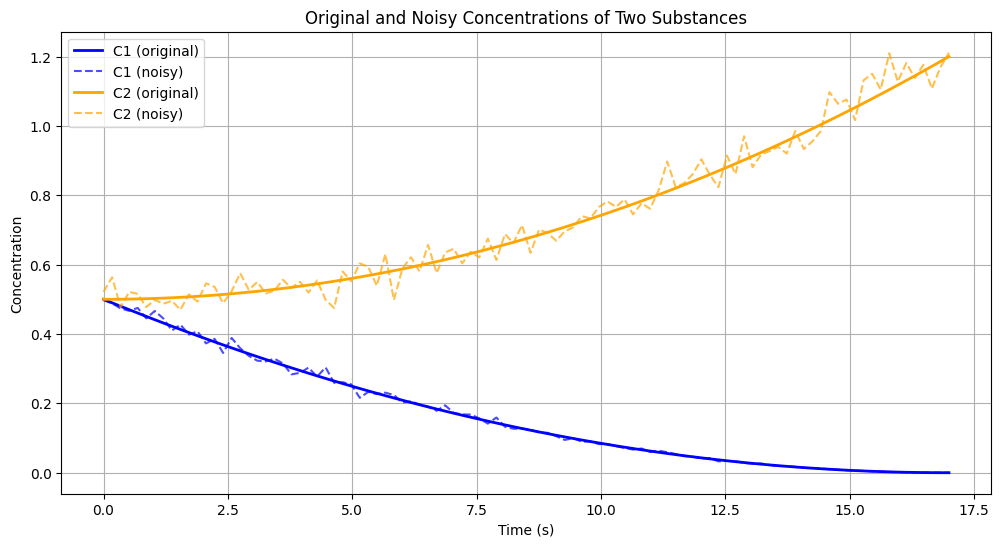

In [112]:
import numpy as np
import matplotlib.pyplot as plt

# Исходные данные
time = np.linspace(0, 17, 100)  # Временные шаги
C1 = 0.5 * (1 - time / 17)**2   # Зависимость концентрации первого вещества
C2 = 0.5 + (1.2 - 0.5) * (time / 17)**2  # Зависимость концентрации второго вещества

# Уровень шума
noise_level = 0.05  # Относительный уровень шума (регулируется)

# Генерация шума
noise_C1 = np.random.randn(*C1.shape) * C1 * noise_level
noise_C2 = np.random.randn(*C2.shape) * C2 * noise_level

# Зашумленные данные
C1_noisy = C1 + noise_C1
C2_noisy = C2 + noise_C2

# Построение графиков
plt.figure(figsize=(12, 6))
plt.plot(time, C1, label="C1 (original)", color='blue', linewidth=2)
plt.plot(time, C1_noisy, '--', label="C1 (noisy)", color='blue', alpha=0.7)
plt.plot(time, C2, label="C2 (original)", color='orange', linewidth=2)
plt.plot(time, C2_noisy, '--', label="C2 (noisy)", color='orange', alpha=0.7)
plt.xlabel("Time (s)")
plt.ylabel("Concentration")
plt.title("Original and Noisy Concentrations of Two Substances")
plt.legend()
plt.grid(True)
plt.show()
